In [ ]:
import pygame
import numpy as np
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.layers import Dense, Flatten, Conv2D,Input
from keras._tf_keras.keras.optimizers import Adam
import random
import pickle
import copy
from os import path

if path.exists('datalist.pkl')==1:
    with open('datalist.pkl', 'rb') as file:  # 'rb' 代表讀取二進位檔案
        loaded_data = pickle.load(file)
        memory = loaded_data[0]
        epsilon = loaded_data[1]
        epoch_tr = loaded_data[2]
        point_record = loaded_data[3]
else:
    loaded_data = []
    memory = [(np.array([[0, 0, 0, 0],
                         [0, 0, 0, 0],
                         [0, 0, 0, 0],
                         [0, 0, 0, 0]]),
                         0,
                         0,
               np.array([[0, 0, 0, 0],
                         [0, 0, 0, 0],
                         [0, 0, 0, 0],
                         [0, 0, 0, 0]]), 0)]
    epsilon = 1
    epoch_tr = 0
    point_record = []

move_count=1
done = False
ram_point=0
out_put = ''
now_point=0
best_point=0
dead = 0

old_cage=np.array([[0,0,0,0],
                   [0,0,0,0],
                   [0,0,0,0],
                   [0,0,0,0]])

cage = np.array([[0,1,0,0],
                 [0,0,0,0],
                 [0,0,1,0],
                 [0,0,0,0]])

# 參數
gamma = 0.95  # 折扣因子
epsilon_decay = 0.985
epsilon_min = 0.01  
batch_size = 64
max_now = 8
move_count = 1

#for i in range(0,random.randint(2,3)):
#   cage[random.randint(0,3),random.randint(0,3)] = 1



# 设置游戏参数
block_size = 50
DISPLAY_WIDTH = 600
DISPLAY_HEIGHT = 750
#常用顏色
BROWN = (172,157,143)
LIGHT_BROWN = (192,179,164)
#建立視窗及頻率鐘
gameDisplay = pygame.display.set_mode((DISPLAY_WIDTH, DISPLAY_HEIGHT))
pygame.display.set_caption('2048AI')
clock = pygame.time.Clock()
# 初始化pygame
pygame.init()
pygame.font.init()

In [ ]:
def normalization(array):
    _range = np.max(array)-np.min(array)
    return ((array-np.min(array))/_range)+1

def print_on_screen(text='',sizes=30,place=(450,90)):
    my_font = pygame.font.SysFont('clear-sans.bold', sizes)
    text_surface = my_font.render(text, False, (77,57,0))
    gameDisplay.blit(text_surface,place)

def block_place(b,a):

    '''
    a=(0,1,2,3)
    b=(0,1,2,3)
    從左到右，從上到下
    '''
    an=30+a*140
    bn=180+b*140
    return (an,bn)

def load(num):
    pygame.image.load('image'+'\\'+str(2**num)+'.png')

for i in range(1,19): block = load(i)

def put_image(place,image,getting_big=0):

    '''
    place=(x,y)
    image=log(target_number)
    getting big=0(no) 1(yes)

    '''
    if getting_big == 1:
        for i in range(1,6):
            now_image=pygame.image.load('image'+'\\'+str(2**image)+'.png')
            now_image=pygame.transform.scale(now_image, (24*i, 24*i))
            gameDisplay.blit( now_image ,(place[0]+60-12*i,place[1]+60-12*i))
            pygame.display.update()
    else:
        now_image=pygame.image.load('image'+'\\'+str(2**image)+'.png')
        now_image=pygame.transform.scale(now_image, (120, 120))
        gameDisplay.blit( now_image , place)

def detecting (cage,n=0):
    emptyplace = np.where( cage== n)
    x=emptyplace[0]
    y=emptyplace[1]
    return x,y 

def move_direcrion(behave_input=0,cage_def=np.array([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]])):

    old_part=cage_def
    moving = 0
    point = 0
    ram_change_def = 0
    reply_message = ''

    if random.randint(0,9)==0:
        new_block = 2
    else:
        new_block = 1

    for plc_x in [0,1,2]:
        for plc_y in [0,1,2,3]:
            if old_part[plc_x,plc_y]==old_part[plc_x+1,plc_y]:moving=1
    
    for plc_x in [0,1,2,3]:
        for plc_y in [0,1,2]:
            if old_part[plc_x,plc_y]==old_part[plc_x,plc_y+1]:moving=1

    empty_x,empty_y = detecting(old_part)

    if moving == 0 and len(empty_x) == 0:
        reply_message = 'unmoveable'
        return old_part,point,reply_message
    
    if behave_input == 1 :             #right move
        for i in range(0,4):
            ram = old_part[i,0:4]
            ram_b = old_part[i,0:4]
            for j in [3,3,2,3,2,1,3,2,1,0]: 
                if ram[j] == 0:
                    ram=np.delete(ram,j)
                    ram=np.insert(ram,0,0)
            for k in [3,2,1]:
                if (ram[k] == ram[k-1]) and (ram[k] !=0) :
                    point = point+(2**(ram[k-1]+1))
                    ram[k-1]=ram[k]+1
                    ram=np.delete(ram,k)
                    ram=np.insert(ram,0,0)
            if np.array_equal(ram,ram_b)==0:
                ram_change_def+=1
            old_part[i,0:4] = ram


        if ram_change_def!=0:
            empty_x,empty_y = detecting(old_part)
            ran=random.randint(0,len(empty_x)-1)
            old_part[empty_x[ran],empty_y[ran]] = new_block
            reply_message='moving rignt'
            #put_image(block_place(empty_x[ran],empty_y[ran]),new_block,1)

        else:
            reply_message='didnt move'

    if behave_input == 2 :             #down move
        for i in range(0,4):
            ram = old_part[0:4,i]
            ram_b = old_part[0:4,i]
            for j in [3,3,2,3,2,1,3,2,1,0]: 
                if ram[j] == 0:
                    ram=np.delete(ram,j)
                    ram=np.insert(ram,0,0)
            for k in [3,2,1]:
                if (ram[k] == ram[k-1]) and (ram[k] !=0) :
                    point = point+(2**(ram[k-1]+1))
                    ram[k-1]=ram[k]+1
                    ram=np.delete(ram,k)
                    ram=np.insert(ram,0,0)
            if np.array_equal(ram,ram_b)==0:
                ram_change_def+=1
            old_part[0:4,i] = ram


        if ram_change_def!=0:
            empty_x,empty_y = detecting(old_part)
            ran=random.randint(0,len(empty_x)-1)
            old_part[empty_x[ran],empty_y[ran]] = new_block
            reply_message='moving down'
            #put_image(block_place(empty_x[ran],empty_y[ran]),new_block,1)

        else:
            reply_message='didnt move'

    if behave_input == 3 :             #left move
        for i in range(0,4):
            ram = old_part[i,0:4]
            ram_b = old_part[i,0:4]
            for j in [0,0,1,0,1,2,0,1,2,3]: 
                if ram[j] == 0:
                    ram=np.delete(ram,j)
                    ram=np.insert(ram,3,0)
            for k in [0,1,2]:
                if (ram[k] == ram[k+1]) and (ram[k] !=0) :
                    point = point+(2**(ram[k]+1))
                    ram[k+1]=ram[k]+1
                    ram=np.delete(ram,k)
                    ram=np.insert(ram,3,0)
            if np.array_equal(ram,ram_b)==0:
                ram_change_def+=1
            old_part[i,0:4] = ram


        if ram_change_def!=0:
            empty_x,empty_y = detecting(old_part)
            ran=random.randint(0,len(empty_x)-1)
            old_part[empty_x[ran],empty_y[ran]] = new_block
            reply_message='moving left'
            #put_image(block_place(empty_x[ran],empty_y[ran]),new_block,1)

        else:
            reply_message='didnt move'

    if behave_input == 4 :             #up move
        for i in range(0,4):
            ram = old_part[0:4,i]
            ram_b = old_part[0:4,i]
            for j in [0,0,1,0,1,2,0,1,2,3]: 
                if ram[j] == 0:
                    ram=np.delete(ram,j)
                    ram=np.insert(ram,3,0)
            for k in [0,1,2]:
                if (ram[k] == ram[k+1]) and (ram[k] !=0) :
                    point = point+(2**(ram[k]+1))
                    ram[k+1]=ram[k]+1
                    ram=np.delete(ram,k)
                    ram=np.insert(ram,3,0)
            if np.array_equal(ram,ram_b)==0:
                ram_change_def+=1
            old_part[0:4,i] = ram

        if ram_change_def!=0:
            empty_x,empty_y = detecting(old_part)
            ran=random.randint(0,len(empty_x)-1)
            old_part[empty_x[ran],empty_y[ran]] = new_block
            reply_message = 'moving up'
            #put_image(block_place(empty_x[ran],empty_y[ran]),new_block,1)

        else:
            reply_message = 'didnt move'

    return old_part,point,reply_message

def test_validation(cage):

    cage_use=copy.deepcopy(cage)
    validation=[]     
    ram_change_def = 0
    for i in range(0,4):    #right move
        ram = cage_use[i,0:4]
        ram_b = cage_use[i,0:4]
        for j in [3,3,2,3,2,1,3,2,1,0]: 
            if ram[j] == 0:
                ram=np.delete(ram,j)
                ram=np.insert(ram,0,0)
        for k in [3,2,1]:
            if (ram[k] == ram[k-1]) and (ram[k] !=0) :
                ram[k-1]=ram[k]+1
                ram=np.delete(ram,k)
                ram=np.insert(ram,0,0)
        if np.array_equal(ram,ram_b)==0:
            ram_change_def+=1
        cage_use[i,0:4] = ram

    if ram_change_def != 0: validation.append(1)
    else: validation.append(0)

    cage_use=copy.deepcopy(cage)
    ram_change_def = 0

    for i in range(0,4):
        ram = cage_use[0:4,i]
        ram_b = cage_use[0:4,i]
        for j in [3,3,2,3,2,1,3,2,1,0]: 
            if ram[j] == 0:
                ram=np.delete(ram,j)
                ram=np.insert(ram,0,0)
        for k in [3,2,1]:
            if (ram[k] == ram[k-1]) and (ram[k] !=0) :
                ram[k-1]=ram[k]+1
                ram=np.delete(ram,k)
                ram=np.insert(ram,0,0)
        if np.array_equal(ram,ram_b)==0:
            ram_change_def+=1
        cage_use[0:4,i] = ram
        
    if ram_change_def != 0: validation.append(1)
    else: validation.append(0)

    cage_use=copy.deepcopy(cage)
    ram_change_def = 0

    for i in range(0,4):
        ram = cage_use[i,0:4]
        ram_b = cage_use[i,0:4]
        for j in [0,0,1,0,1,2,0,1,2,3]: 
            if ram[j] == 0:
                ram=np.delete(ram,j)
                ram=np.insert(ram,3,0)
        for k in [0,1,2]:
            if (ram[k] == ram[k+1]) and (ram[k] !=0) :
                ram[k+1]=ram[k]+1
                ram=np.delete(ram,k)
                ram=np.insert(ram,3,0)
        if np.array_equal(ram,ram_b)==0:
            ram_change_def+=1
        cage_use[i,0:4] = ram

    if ram_change_def != 0: validation.append(1)
    else: validation.append(0)

    cage_use=copy.deepcopy(cage)
    ram_change_def = 0

    for i in range(0,4):
        ram = cage_use[0:4,i]
        ram_b = cage_use[0:4,i]
        for j in [0,0,1,0,1,2,0,1,2,3]: 
            if ram[j] == 0:
                ram=np.delete(ram,j)
                ram=np.insert(ram,3,0)
        for k in [0,1,2]:
            if (ram[k] == ram[k+1]) and (ram[k] !=0) :
                ram[k+1]=ram[k]+1
                ram=np.delete(ram,k)
                ram=np.insert(ram,3,0)
        if np.array_equal(ram,ram_b)==0:
            ram_change_def+=1
        cage_use[0:4,i] = ram
        
    if ram_change_def != 0: validation.append(1)
    else: validation.append(0)

    cage_use=copy.deepcopy(cage)

    return validation

def calculate_penalty(board, move_count,previous):
    """
    計算兩種懲罰機制的總懲罰值。

    board: 4x4 的 NumPy 數組表示的棋盤。
    move_count: 當前的移動次數。
    move_weight: 與移動次數相關的參數。
    """
    penalty = 0
    
    # 1. 懲罰：相同值方塊數量過多
    unique, counts = np.unique(board, return_counts=True)
    for value, count in zip(unique, counts):
        if ((value > 4 and count > 1)or (value >1 and count>2)) and move_count>50:  # 忽略 0 值
            penalty -= (value + 1)*(count - 1)
    
    # 2. 懲罰：最大數值不在角落
    max_value = board.max()
    max_position = np.argwhere(board == max_value)
    
    # 檢查是否在四個角落
    corners = [(0, 0), (0, 3), (3, 0), (3, 3)]
    is_in_corner = any(tuple(pos) in corners for pos in max_position)
    if not is_in_corner:
        was_in_corner = any(tuple(pos) in corners for pos in previous)
        if not was_in_corner:
            penalty -=0.1* max_value * ((np.e)**((move_count)/500))
    
    return penalty

def build_q_model():
    
    model = Sequential()
    
    model.add(Input(shape=(4,4,1)))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    
    model.add(Conv2D(128, (2, 2), padding='same', activation='relu'))

    model.add(Flatten())

    model.add(Dense(256, activation='relu'))

    model.add(Dense(4, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    return model


# 選擇動作 (ε-greedy)
def choose_action(state, model, valid_move):
    if (np.random.rand() <= epsilon) & (epsilon >= 0.1):
        #print('choose random')
        return random.randint(0,3)  # 隨機選擇動作
    q_values = model.predict(np.expand_dims(state, axis=0),verbose=0)
    #print('choose model')
    q_valid = np.multiply(np.array(valid_move),normalization(q_values[0]))
    return np.argmax(q_valid)

# 儲存經驗
def store_experience(memory, state, action, reward, next_state, done):
    memory.append((copy.deepcopy(state), action, reward, copy.deepcopy(next_state), done))
    if len(memory) > 2000:
        memory.pop(0)

# 訓練Q模型
def train_q_model(model, memory):

    if len(memory) < batch_size:
        return
    minibatch = random.sample(memory, batch_size)
    
    states = []
    targets = []
    
    for state, action, reward, next_state, done in minibatch:
        target = reward
        if not done:
            target = reward + gamma * np.amax(model.predict(np.expand_dims(next_state, axis=0),verbose=0)[0])
        q_values = model.predict(np.expand_dims(state, axis=0),verbose=0)[0]
        q_values[action] = target
        
        states.append(state)
        targets.append(q_values)
    
    # 將列表轉換為 NumPy 陣列
    states = np.array(states)
    targets = np.array(targets)
    
    # 在整個批次上訓練模型
    model.fit(states, targets, epochs=1, verbose=1)

# 初始化 Q-learning 模型
q_model = build_q_model()

if path.exists("2048_weights.h5")==1:
    q_model.load_weights("2048_weights.h5")

def display_cage(cage_now):
    for i in [0,1,2,3]:
        for j in [0,1,2,3]:
            if cage_now[i,j]!=0:
                put_image(block_place(i,j),cage_now[i,j])

def display_all(cage):
    gameDisplay.fill(BROWN)
    for i in [30,170,310,450]:
        for j in [180,320,460,600]:pygame.draw.rect(gameDisplay,LIGHT_BROWN,(i,j,120,120),0,20) 
    display_cage(cage)
    pygame.draw.rect(gameDisplay,LIGHT_BROWN,(440,110,150,60),0,10)
    pygame.draw.rect(gameDisplay,LIGHT_BROWN,(440,40,150,60),0,10)
    print_on_screen('NOW POINT',30,(455,115))
    print_on_screen('BEST POINT',30,(453,45))
    print_on_screen('2 0 4 8',150,(45,30))
    epoch_word='epoch='+str(epoch_tr)+',training for best point'
    print_on_screen(epoch_word,40,(10,130))
    print_on_screen(str(best_point),50,(445,65))
    print_on_screen(str(now_point),50,(445,135))
    pygame.display.update()

print(cage)

[[0 1 0 0]
 [0 0 0 0]
 [0 0 1 0]
 [0 0 0 0]]


In [ ]:
if __name__ == "__main__":
    

    while not done:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                q_model.save_weights("2048_weights.weights.h5")
                save_list=[memory,epsilon,epoch_tr,point_record]
                while len(save_list) > 1000:
                    save_list.pop()

                with open('datalist.pkl', 'wb') as file:
                    pickle.dump(save_list, file)
                    
                    print(f"List 已保存為 PKL 檔案: {'datalist.pkl'}")
                print('saved model to disk')
                done = True

        
        # epsilon-greedy選動作
        action = choose_action(cage,q_model,test_validation(copy.deepcopy(cage)))
        new_cage,ram_point,out_put = move_direcrion(action+1,cage)

        now_point=now_point+ram_point
        
        if 2**np.max(new_cage)> max_now:
            reward = (2**np.max(new_cage))*((np.e)**((-move_count)/100))
            max_now = 2**np.max(new_cage)
        else:
            reward = 0

        reward += ram_point
        
        move_count += 1
        
        if epoch_tr >= 100 :reward += calculate_penalty(new_cage,move_count,cage)

        if best_point <= now_point:
            best_point = now_point 
        
        #display_all(cage)
                
        if out_put == 'unmoveable':
            dead = 1
            reward = -15
            print('game over')
            print('final point:',now_point)


        cage=memory[-1][3]

        store_experience(memory,cage,action,reward,new_cage,dead)
        
        cage=memory[-1][3]

    # 死亡時訓練和重置
        if dead == 1:

            print(new_cage)

            train_q_model(q_model,memory)
            if epsilon > epsilon_min:
                epsilon *= epsilon_decay

            dead = 0
            point_record.append((now_point,copy.deepcopy(max_now),move_count))


            cage=np.array([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]])
            for i in range(0,random.randint(2,3)):
                cage[random.randint(0,3),random.randint(0,3)] = 1

            ram_point = 0
            out_put = ''
            now_point = 0
            max_now = 16
            move_count = 0
            epoch_tr += 1  
            print(epoch_tr)
            
        clock.tick(60)

    pygame.quit()

game over
final point: 1392
[[7 1 5 1]
 [6 5 3 2]
 [4 3 2 1]
 [3 2 1 2]]
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 66.4057 
148
game over
final point: 640
[[1 3 4 2]
 [4 6 5 4]
 [3 2 1 2]
 [2 1 3 1]]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 87.8762
149
game over
final point: 648
[[4 6 1 4]
 [1 4 5 3]
 [4 3 2 1]
 [1 2 3 2]]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 63.2668
150
game over
final point: 1564
[[1 3 1 5]
 [3 6 7 2]
 [2 3 6 1]
 [1 2 3 2]]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 70.2772
151
game over
final point: 1328
[[5 1 6 1]
 [3 6 5 3]
 [6 4 3 2]
 [4 3 2 1]]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 181.7523
152
game over
final point: 1196
[[4 2 1 4]
 [3 5 7 3]
 [2 3 5 2]
 [1 4 2 1]]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 159.3472
153
game over
final point: 1232
[[1 6 2 1]
 [4 1 3 2]
 [2 4 7 4]
 [1 2 3 1]]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 73.7920
154
game over
final point: 512
[[1 2 3 1]
 [2 3 4 2]
 [3 6 1 4]
 [1 3 4 1]]
4/4 ━━━━━━

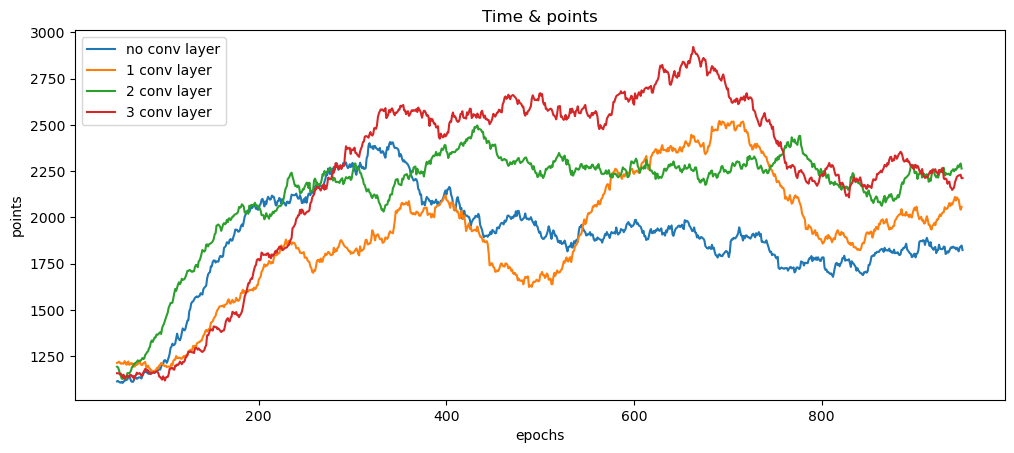

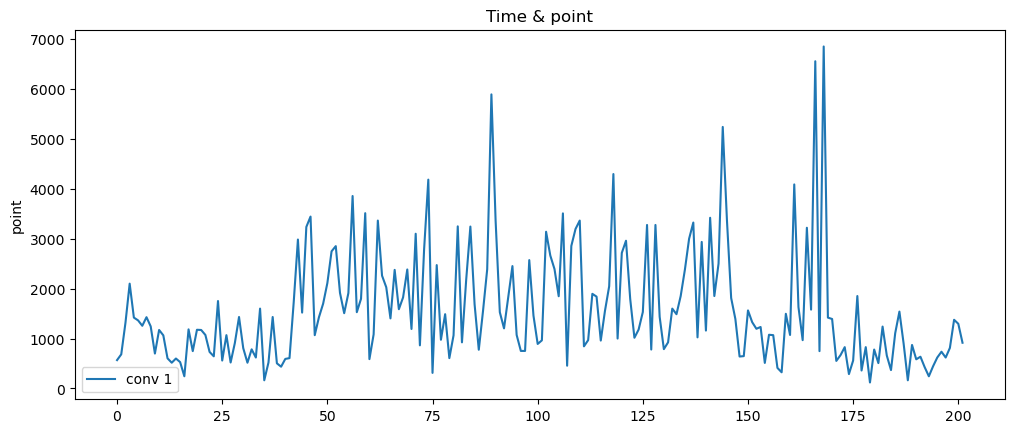

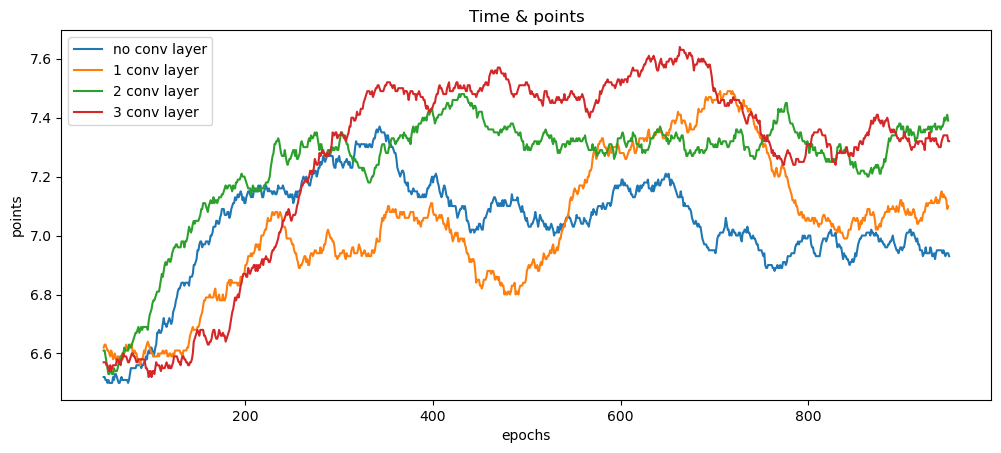

In [20]:
import matplotlib.pyplot as plt

def show_train_history(la,lb,lc,ld):
    plt.figure(figsize=(12,4.8))
    plt.plot(la)
    plt.plot(lb)
    plt.plot(lc)
    plt.plot(ld)
    plt.title('Time & points')
    plt.ylabel('points')
    plt.xlabel('epochs')
    plt.legend(['no conv layer','1 conv layer','2 conv layer','3 conv layer'], loc='upper left')
    plt.show()

def show_train_history_one(la,title):
    plt.figure(figsize=(12,4.8))
    plt.plot(la)
    plt.title('Time & point')
    plt.ylabel('point')
    plt.legend([title], loc='lower left')
    plt.show()

def moving_average(data, window_size):
    # 將輸入數據轉換為 numpy array
    data = np.array(data)
    
    # 使用 numpy 的 convolve 函數計算移動平均
    weights = np.ones(window_size) / window_size
    moving_avg = np.convolve(data, weights, mode='valid')

    pad_size = window_size - 1
    # 在開頭和結尾填充 NaN 或其他值（這裡用 NaN）
    pad_width = (pad_size // 2, pad_size - pad_size // 2)
    moving_avg = np.pad(moving_avg, pad_width, mode='constant', constant_values=np.nan)
                        
    return moving_avg

if path.exists('datalist zero conv.pkl')==1:
    with open('datalist zero conv.pkl', 'rb') as file:  # 'rb' 代表讀取二進位檔案
        loaded_data_d = pickle.load(file)
        point_record_d = loaded_data_d[3]


if path.exists('datalist one conv.pkl')==1:
    with open('datalist one conv.pkl', 'rb') as file:  # 'rb' 代表讀取二進位檔案
        loaded_data_a = pickle.load(file)
        point_record_a = loaded_data_a[3]

if path.exists('datalist two conv.pkl')==1:
    with open('datalist two conv.pkl', 'rb') as file:  # 'rb' 代表讀取二進位檔案
        loaded_data_b = pickle.load(file)
        point_record_b = loaded_data_b[3]

if path.exists('datalist three conv.pkl')==1:
    with open('datalist three conv.pkl', 'rb') as file:  # 'rb' 代表讀取二進位檔案
        loaded_data_c = pickle.load(file)
        point_record_c = loaded_data_c[3]

show_train_history(moving_average([t[0] for t in point_record_d],100),
                   moving_average([t[0] for t in point_record_a],100),
                   moving_average([t[0] for t in point_record_b],100),
                   moving_average([t[0] for t in point_record_c],100))

show_train_history_one([t[0] for t in point_record],'conv 1')

show_train_history(moving_average([np.log2(t[1]) for t in point_record_d],100),
                   moving_average([np.log2(t[1]) for t in point_record_a],100),
                   moving_average([np.log2(t[1]) for t in point_record_b],100),
                   moving_average([np.log2(t[1]) for t in point_record_c],100))
#show_train_history([t[2] for t in point_record_a],moving_average([t[2] for t in point_record_a],10))

#毫無目的的亂用，參數基本都沒變，還沒增加布林遮罩來去除不該發生的動作   (round 1)

#前150次decline rate是0.995，之後50次是0.9695，最後30次是0.925   (round 2)

#decline rate是0.985(150次到0.1)，epsilon到0.1之後完全放給Qmodel   (round 3)

#新增空格數量的reward，準備運行200次觀察結果   (round 4)
#第400次的時候數據不小心被汙染了嗚嗚嗚

#取回第三次的模型和資料來重新跑看看   (round 5)
#找到我出問題的地方了，空格數量的reward很容易一不小心就太大

#明天重新試   (round 6)
#效果不太好，刪掉了空格數量的reward

#改用CNN模型嘗試，速度好慢嗚嗚嗚   (round 7)
#應該增加懲罰機制，假如最大數量多於一塊那麼-15reward，同時最大數量不在角落-(最大方塊的值*10)reward
#decline rate應該更低

#增加了以上改動後開始進行第八次嘗試   (round 8)
#超失敗

#把decline rate調回來了，minibatch從256回到64，還有把懲罰機制減緩   (round 9)
#在170次後分數開始下降，或許我應該去掉移動時分數增加的獎勵

#效果不彰且不穩定   (round 10)


In [4]:

    
model = build_q_model()



print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 128)      │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 592,516 (2.26 MB)

 Trainable params: 592,516 (2.26 MB)

 Non-trainable params: 0 (0.00 B)

None
